In [1]:
##Whoops. I think i gotta go to the terminal and do it there.

# !pip install black
# import black

In [2]:
#!/usr/bin/env python
# Hello!
# ! git clone -b BinaryLove https://git.ligo.org/cjhaster/bilby.git
import sys

sys.path.insert(0, "/home/marc.penuliar/bilby")
import bilby
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

No version information file '.version' found


In [3]:
# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "bns_example"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

In [4]:
# Set up a random seed for result reproducibility.  This is optional!
# np.random.seed(88170235)

In [5]:
# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.
injection_parameters = dict(
    mass_1=1.5,
    mass_2=1.3,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    # lambda_1= 400, #545.21397414, was 400 182.367432516109
    # lambda_2= 450 #1346.68123938, was 450
    lambda_1=545.21397414,
    lambda_2=1346.68123938,
)

# lambda_1 =545.21397414 #
# lambda_2 =1346.68123938  #

In [6]:
# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 4096  # 2048 #4096 changed for later. we need faster test runs
start_time = injection_parameters["geocent_time"] + 2 - duration

In [7]:
# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",  # IMRPhenomPv2_NRTidal
    reference_frequency=50.0,
    minimum_frequency=40.0,
)

In [8]:
# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)
##

11:09 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


In [9]:
# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

11:09 bilby INFO    : Injected signal in H1:
11:09 bilby INFO    :   optimal SNR = 34.49
11:09 bilby INFO    :   matched filter SNR = 34.36-0.99j
11:09 bilby INFO    :   mass_1 = 1.5
11:09 bilby INFO    :   mass_2 = 1.3
11:09 bilby INFO    :   chi_1 = 0.02
11:09 bilby INFO    :   chi_2 = 0.02
11:09 bilby INFO    :   luminosity_distance = 50.0
11:09 bilby INFO    :   theta_jn = 0.4
11:09 bilby INFO    :   psi = 2.659
11:09 bilby INFO    :   phase = 1.3
11:09 bilby INFO    :   geocent_time = 1126259642.413
11:09 bilby INFO    :   ra = 1.375
11:09 bilby INFO    :   dec = -1.2108
11:09 bilby INFO    :   lambda_1 = 545.21397414
11:09 bilby INFO    :   lambda_2 = 1346.68123938
11:09 bilby INFO    : Injected signal in L1:
11:09 bilby INFO    :   optimal SNR = 27.92
11:09 bilby INFO    :   matched filter SNR = 27.79+0.32j
11:09 bilby INFO    :   mass_1 = 1.5
11:09 bilby INFO    :   mass_2 = 1.3
11:09 bilby INFO    :   chi_1 = 0.02
11:09 bilby INFO    :   chi_2 = 0.02
11:09 bilby INFO    :   lu

[{'plus': array([ 0.-0.j,  0.-0.j,  0.-0.j, ..., -0.+0.j, -0.+0.j,  0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([ 0.-0.j,  0.-0.j,  0.-0.j, ..., -0.+0.j, -0.+0.j,  0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([ 0.-0.j,  0.-0.j,  0.-0.j, ..., -0.+0.j, -0.+0.j,  0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [10]:
# Load the default prior for binary neutron stars.
# We're going to sample in chirp_mass, symmetric_mass_ratio, lambda_tilde, and
# delta_lambda rather than mass_1, mass_2, lambda_1, and lambda_2.
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    # "phase",
]:
    priors[key] = injection_parameters[key]
del (
    priors["lambda_1"],
    priors["lambda_2"],
    priors["mass_ratio"],
)
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\\odot}$"
)
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
    0.1, 0.25, name="symmetric_mass_ratio"
)

# Using this prior will create lambda1 and lambda2. Outputs are funky
priors["lambda_symmetric"] = bilby.core.prior.Uniform(0, 5000, name="lambda_symmetric")

priors["binary_love_uniform"] = bilby.core.prior.Uniform(
    0, 1, name="binary_love_uniform"
)

priors["lambda_1"] = bilby.core.prior.Constraint(
    name="lambda_1", minimum=0, maximum=10000
)
priors["lambda_2"] = bilby.core.prior.Constraint(
    name="lambda_2", minimum=0, maximum=10000
)

priors["phase"] = bilby.core.prior.Uniform(
    0, 2 * np.pi, boundary="periodic", name="phase"
)
# The next step is to make a larger range for binary love?

# priors["lambda_symmetric"] = bilby.core.prior.Uniform(0, 5000, name="lambda_symmetric")

# priors["lambda_antisymmetric"] = bilby.core.prior.Uniform(-5000, 5000, name="lambda_antisymmetric")

11:09 bilby INFO    : No prior given, using default BNS priors in /home/marc.penuliar/bilby/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


In [11]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
    phase_marginalization=True,
    priors=priors,
)

11:09 bilby INFO    : Running for label 'bns_example', output will be saved to 'outdir'
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:09 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11

No version information file '.version' found
it=  1889 logz=1428.957170800000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


11:23 bilby INFO    : Sampling time: 0:13:09.051672
11:23 bilby INFO    : Reconstructing marginalised parameters.
11:23 bilby INFO    : Cached samples dict out of date, ignoring


  0%|          | 0/1990 [00:00<?, ?it/s]

11:26 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/1990 [00:00<?, ?it/s]

11:26 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/1990 [00:00<?, ?it/s]

11:32 bilby INFO    : Summary of results:
nsamples: 1990
ln_noise_evidence: -193972.813
ln_evidence: -192543.490 +/-  0.410
ln_bayes_factor: 1429.323 +/-  0.410



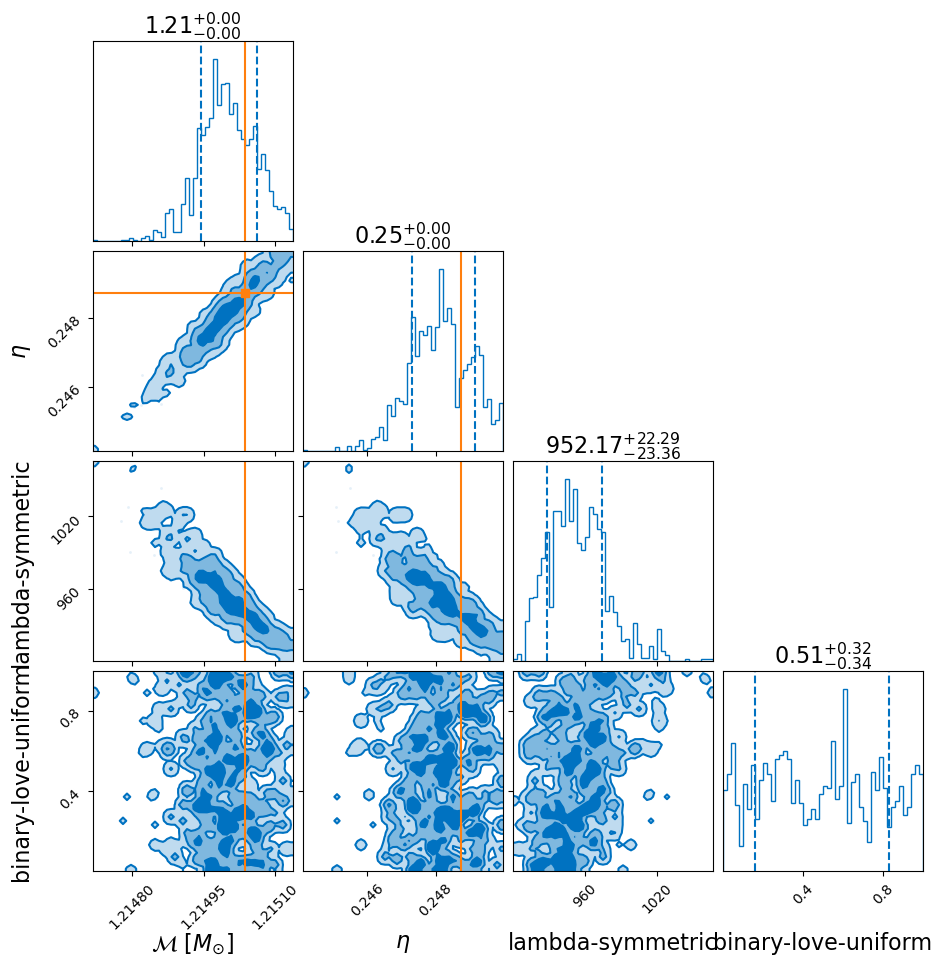

In [12]:
# Run sampler.  In this case we're going to use the `nestle` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nestle",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
)

result.plot_corner()

In [13]:
# lambda1 and lambda2 is not here but the plot below works.
# print(result.posterior)

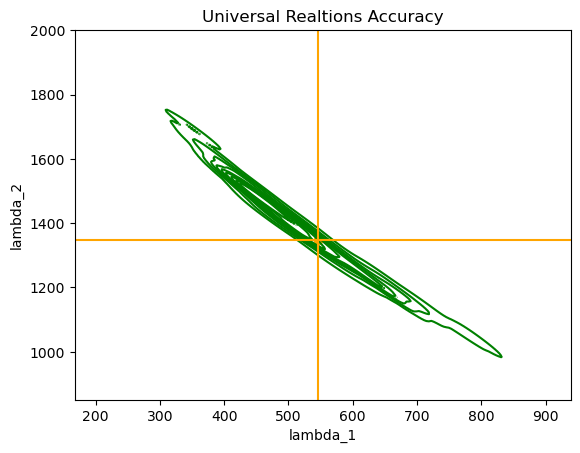

In [14]:
# This is confusing, since lambda1 and lambda2 does not appear in the posterior samples. But does plot.
# The next cell proves that lambda1 and lambda2 are not in the results.posterior samples.

sns.kdeplot(
    x=result.posterior["lambda_1"],
    y=result.posterior["lambda_2"],
    color="green",
    label="Binary_love_&_LambdaSymm",
)

# title
plt.title("Universal Realtions Accuracy")

# lambda 2 y
plt.axhline(y=result.injection_parameters["lambda_2"], color="orange", linestyle="-")
# lambda 2 x
plt.axvline(x=result.injection_parameters["lambda_1"], color="orange")
# Add the point
plt.scatter(
    result.injection_parameters["lambda_1"],
    result.injection_parameters["lambda_2"],
    color="orange",
)

plt.show()

In [15]:
# # Finds the injection samples for creating the orange lines and make our true_value_lambdaASymm

# injection_lambda_1 = result.injection_parameters["lambda_1"]
# injection_lambda_2 = result.injection_parameters["lambda_2"]

# true_value_lambdaASymm = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_antisymmetric(
#     injection_lambda_1, injection_lambda_2
# )
# print(true_value_lambdaASymm)

In [16]:
# # Used to create the 1D kde plot
# lambdaASymm = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_antisymmetric(
#     result.posterior["lambda_1"], result.posterior["lambda_2"]
# )

In [17]:
# # PLotting with True value
# sns.histplot(x=lambdaASymm, kde=True, element="step").axvline(
#     true_value_lambdaASymm, color="orange"
# )
# plt.xlabel("lambdaASymm")
# plt.legend(labels=["Hist", "KDE", "True Value = 400.73"])
# plt.show()

In [18]:
# # Checking on Binary_love_uniform

# sns.histplot(
#     x=result.posterior["binary_love_uniform"], kde=True, element="step"
# )  # .axvline(true_value_lambdaASymm, color ='orange' ).set(xlabel='common xlabel', ylabel='common ylabel')
# plt.legend(labels=["Hist", "KDE"])  # , 'True Value = 400.73'])
# plt.show()

In [19]:
# def massratio(mass1, mass2):
#     q = mass2 / mass1
#     return q


# # nonsymm_mass_ratio
# mass_ratio = massratio(
#     result.posterior["mass_1_source"], result.posterior["mass_2_source"]
# )

In [20]:
# # Applying the function. This graph comes out weird.

# binary_love = result.posterior["binary_love_uniform"]
# lambdaSymm = result.posterior["lambda_symmetric"]
# # symm_mass_ratio = result.posterior['symmetric_mass_ratio']

# # makes lambda1 and lamdba2:
# lambdas = bilby.gw.conversion.binary_love_lambda_symmetric_to_lambda_1_lambda_2_manual_marginalisation(
#     binary_love, lambdaSymm, mass_ratio
# )

# lambda1 = lambdas[0]

# lambda2 = lambdas[1]

In [21]:
# # With the use of the Function to create lambda1 and lambda2. This is the plot that is made.

# sns.kdeplot(x=lambda1, y=lambda2, color="green", label="Binary_love_&_LambdaSymm")

# # Title
# plt.title("With Function")

# # lambda 2 y
# plt.axhline(y=result.injection_parameters["lambda_2"], color="orange", linestyle="-")
# # lambda 2 x
# plt.axvline(x=result.injection_parameters["lambda_1"], color="orange")
# # Add the point
# plt.scatter(
#     result.injection_parameters["lambda_1"],
#     result.injection_parameters["lambda_2"],
#     color="orange",
# )
# plt.show()